### Bars and Stripes

Import libraries

In [1]:
import numpy as np
import pennylane as qml
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from pennylane import numpy as pnp

import jax
import jax.numpy as jnp

jax.config.update("jax_enable_x64", True)

import optax

from pennylane import numpy as pnp
import matplotlib.pyplot as plt
from pennylane_qiskit import AerDevice
from pennylane_ionq import ops
from qiskit_aer import AerSimulator


Generate Bars and Stripes dataset

In [2]:
def get_bars_and_stripes(n):
    bitstrings = [list(np.binary_repr(i, n))[::-1] for i in range(2**n)]
    bitstrings = np.array(bitstrings, dtype=int)

    stripes = bitstrings.copy()
    stripes = np.repeat(stripes, n, 0)
    stripes = stripes.reshape(2**n, n * n)

    bars = bitstrings.copy()
    bars = bars.reshape(2**n * n, 1)
    bars = np.repeat(bars, n, 1)
    bars = bars.reshape(2**n, n * n)
    return np.vstack((stripes[0 : stripes.shape[0] - 1], bars[1 : bars.shape[0]]))


#Size of Bars and Stripes
n = 3
size = n**2
n_qubits = size
data = get_bars_and_stripes(n)

bitstrings = []
nums = []
for d in data:
    bitstrings += ["".join(str(int(i)) for i in d)]
    nums += [int(bitstrings[-1], 2)]
probs = np.zeros(2**size)
probs[nums] = 1 / len(data)

#Seeding
params = np.random.random(size=n_qubits*6*3+1)
paramsoriginal = params

#Noise cooficient
p=0

Visualize dataset

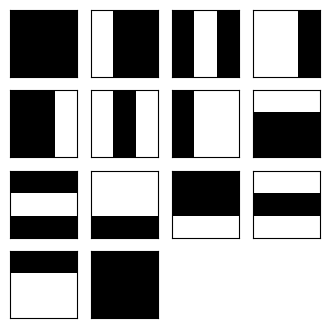

In [73]:
BAS = data.tolist()

j = 1
plt.figure(figsize=[4, 4])
for i in BAS:
    plt.subplot(4, 4, j)
    j += 1
    plt.imshow(np.reshape(i, [3, 3]), cmap="grey")
    plt.xticks([])
    plt.yticks([])

Define the used pennylane device

In [3]:

#dev = AerDevice(wires=n_qubits, backend='aer_simulator')
#dev = qml.device("ionq.simulator", wires=n_qubits)
#dev = qml.device("default.qubit", wires=n_qubits)
dev = qml.device("default.mixed", wires=n_qubits)
#dev = qml.device("qiskit.aer", wires=n_qubits)


# Circuits

In [4]:
def qdi_layer(parameters):
    param_index = 0
    m = 1
    d = 4
    
    for i in range(m):
        # Apply parameterized gates
        for qubit in range(n_qubits):
            qml.RX(parameters[param_index], qubit)
            param_index += 1
        # Apply CNOT gates for entanglement
        for qubit in range(n_qubits - 1):
            qml.CNOT(wires=[qubit, qubit + 1])
        qml.CNOT(wires=[n_qubits - 1, 0])

    for i in range(d):
        for qubit in range(n_qubits):
            qml.RZ(parameters[param_index], qubit)
            param_index += 1

        for j in range(m):
            # Apply parameterized gates
            for qubit in range(n_qubits):
                qml.RX(parameters[param_index], qubit)
                param_index += 1
            # Apply CNOT gates for entanglement
            for qubit in range(n_qubits - 1):
                qml.CNOT(wires=[qubit, qubit + 1])
            qml.CNOT(wires=[n_qubits - 1, 0])
    for qubit in range(n_qubits):
        qml.BitFlip(p, wires=qubit)
    
    return qml.probs(wires=range(n_qubits))


In [5]:
def pqn_layer(parameters):
    param_index = 0
    i = 6
    for qubit in range(n_qubits):
            qml.RX(parameters[param_index], qubit)
            param_index += 1
    
    for k in range(i):
        # Apply parameterized gates
        for qubit in range(n_qubits):
            qml.RZ(parameters[param_index], qubit)
            param_index += 1
            qml.RY(parameters[param_index], qubit)
            param_index += 1
            qml.RZ(parameters[param_index], qubit)
            param_index += 1
        # Apply CNOT gates for entanglement
        for qubit in range(n_qubits - 1):
            qml.CNOT(wires=[qubit, qubit + 1])
        qml.CNOT(wires=[n_qubits - 1, 0])
    for qubit in range(n_qubits):
        qml.BitFlip(p, wires=qubit)
    return qml.probs(wires=range(n_qubits))


In [6]:
def efq_layer(parameters):
    param_index = 1
    x = parameters[0]
    n = 6
    for k in range(n):
        #W part
        for qubit in range(n_qubits):
            qml.RY(parameters[param_index], qubit)
            param_index += 1
            qml.RZ(parameters[param_index], qubit)
            param_index += 1
            qml.RX(parameters[param_index], qubit)
            param_index += 1

            qml.RZ((2**k + 1)*x, qubit)
            
        for qubit in range(n_qubits - 1):
            qml.CNOT(wires=[qubit, qubit + 1])
        qml.CNOT(wires=[n_qubits - 1, 0])
    for qubit in range(n_qubits):
        qml.BitFlip(p, wires=qubit)
    return qml.probs(wires=range(n_qubits))



In [7]:
def strong_layer(parameters):
    #circuit = strong_layer(n_qubits, params, 6)
    #measurements = qml.from_qiskit(circuit)()
    param_index=0
    for i in range(6):
        for qubit in range(n_qubits):
            qml.RX(parameters[param_index], wires=qubit)
            param_index += 1
            qml.RY(parameters[param_index], wires=qubit)
            param_index += 1
            qml.RZ(parameters[param_index], wires=qubit)
            param_index += 1
        # Apply CNOT gates for entanglement
        for qubit in range(n_qubits - 1):
            qml.CNOT(wires=[qubit, qubit + 1])
        qml.CNOT(wires=[n_qubits - 1, 0])
        #for qubit in range(n_qubits):
        #    qml.BitFlip(0.05, wires=qubit)
    for qubit in range(n_qubits):
        qml.BitFlip(p, wires=qubit)
    return qml.probs(wires=range(n_qubits))


# Strong layer

Choosing the Strong layer

In [8]:
@qml.qnode(dev)
def circuit(parameters):
    return strong_layer(parameters)
jit_circuit = jax.jit(circuit)

Cost function

In [9]:
def costsquare(params):
    output_probs = jit_circuit(params)
    
    target_probs = probs
    cost_value = jnp.sum( jnp.square(target_probs-output_probs))
    return cost_value, target_probs

Optimize the quantum circuit

In [10]:

#params = np.random.random(size=n_qubits*4*3)
params = paramsoriginal


opt = optax.adam(learning_rate=0.1)
opt_state = opt.init(params)


@jax.jit
def update_step(params, opt_state):
    (loss_val, qcbm_probs), grads = jax.value_and_grad(costsquare, has_aux=True)(params)
    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_val


history = []
n_iterations = 100

for i in range(n_iterations):
    params, opt_state, loss_val = update_step(params, opt_state)

    if i%10==0:
        print(f"Step: {i} Loss: {loss_val:.4f}")

    history.append(loss_val)
print(params)
optimal_params=params
output_probs = circuit(optimal_params)



#print(optimal_params)
#print(output_probs)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Step: 0 Loss: 0.0700
Step: 10 Loss: 0.0389
Step: 20 Loss: 0.0284
Step: 30 Loss: 0.0207
Step: 40 Loss: 0.0197
Step: 50 Loss: 0.0175
Step: 60 Loss: 0.0141
Step: 70 Loss: 0.0120
Step: 80 Loss: 0.0114
Step: 90 Loss: 0.0105
[ 1.71896509e+00 -2.17325025e-01 -7.71919848e-01  3.38691121e-01
  1.72758409e+00  1.55295382e+00  7.96162108e-01  6.97908770e-01
  1.58268349e-03  7.71807158e-01  1.28916821e+00  6.05453559e-01
  1.79946012e-01  8.20936817e-01  1.79416950e+00  1.17926502e+00
 -1.25093082e-01  1.19467761e-01  5.22457572e-01  5.58794150e-01
  7.53673016e-01  1.85217784e-02 -3.79835130e-03  1.25471196e-01
 -3.70464275e-02 -6.59755420e-02  1.33221744e+00  6.65446490e-01
 -2.22291984e-01  5.02818702e-01  1.22052691e+00  1.56359743e+00
  1.09877749e-01  1.24531952e+00  7.80598076e-01  6.38508514e-01
  9.07051477e-01  2.83612319e-01  7.74618750e-01 -6.50863680e-02
  1.29106144e-02  7.52141516e-01  3.88677363e-01 -1.47124676e-01
 -1.26877616e+00  1.59923642e+00 -8.19975439e-01  1.37476223e+00
 

Plot histogram of Strong Layer

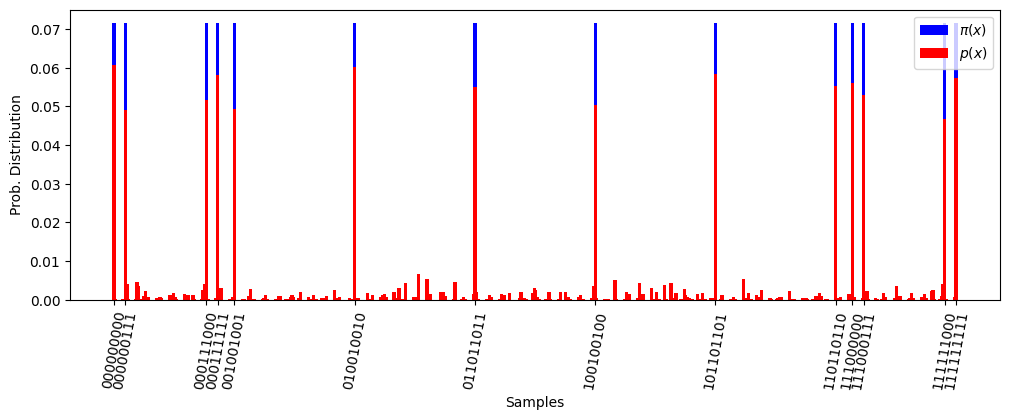

In [11]:
probs = np.zeros(2**size)
probs[nums] = 1 / len(data)

plt.figure(figsize=(12, 5))
plt.bar(np.arange(2**size), probs, width=2.0, label=r"$\pi(x)$", color='blue')
plt.bar(np.arange(2**size), output_probs, width=2.0, label=r"$p(x)$",color='red')

plt.xticks(nums, bitstrings, rotation=80)

plt.xlabel("Samples")
plt.ylabel("Prob. Distribution")
plt.legend(loc="upper right")
plt.subplots_adjust(bottom=0.3)
plt.show()

Accuracy of Strong Layer

In [12]:
acr=0
for i in nums:
    acr+=output_probs[i]
print(acr)

0.7608712304364722


# QDI layer

Choosing the QDI layer

In [13]:
@qml.qnode(dev)
def circuit(parameters):
    return qdi_layer(parameters)
jit_circuit = jax.jit(circuit)

Cost function

In [14]:
def costsquare(params):
    output_probs = jit_circuit(params)
    
    target_probs = probs
    cost_value = jnp.sum( jnp.square(target_probs-output_probs))
    return cost_value, target_probs

Optimize the quantum circuit

In [15]:

#params = np.random.random(size=n_qubits*4*3)
params = paramsoriginal


opt = optax.adam(learning_rate=0.1)
opt_state = opt.init(params)


@jax.jit
def update_step(params, opt_state):
    (loss_val, qcbm_probs), grads = jax.value_and_grad(costsquare, has_aux=True)(params)
    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_val


history2 = []
n_iterations = 100

for i in range(n_iterations):
    params, opt_state, loss_val = update_step(params, opt_state)

    if i%10==0:
        print(f"Step: {i} Loss: {loss_val:.4f}")

    history2.append(loss_val)
print(params)
optimal_params=params
output_probs = circuit(optimal_params)



#print(optimal_params)
#print(output_probs)

Step: 0 Loss: 0.0683
Step: 10 Loss: 0.0531
Step: 20 Loss: 0.0335
Step: 30 Loss: 0.0259
Step: 40 Loss: 0.0208
Step: 50 Loss: 0.0203
Step: 60 Loss: 0.0188
Step: 70 Loss: 0.0186
Step: 80 Loss: 0.0185
Step: 90 Loss: 0.0185
[ 3.10858654e-04  7.32785811e-04 -6.91157114e-03 -3.53377754e-05
 -9.86465129e-04  2.03473552e+00  9.65998492e-01 -5.02080015e-01
  4.04766570e-04  1.18403593e+00 -1.40826297e-01  1.77691326e+00
  3.50943548e-02 -1.38048956e+00  1.63121855e-01  1.01924118e+00
  6.18940564e-01  9.35860230e-02  2.23087379e-01 -3.60839695e-03
 -2.83040814e-01  1.05750825e+00  1.49848222e-02  1.41200057e+00
 -6.21268756e-01  1.57088832e+00  1.57571824e+00 -6.86988865e-01
  8.06332276e-01 -4.31649446e-01  2.03950230e-01 -2.30600854e-01
 -5.35456389e-01  2.13062164e+00  1.57458782e+00  1.16574540e+00
 -4.16818613e-03  1.52409337e-03  4.98585214e-01 -1.54516616e-03
  6.98841853e-03  1.61670526e+00  1.58172271e+00 -1.70508611e-03
  1.06711272e-03  7.94063773e-01  2.44070135e-01  1.05814224e+00
 

Plot histogram of QDI Layer

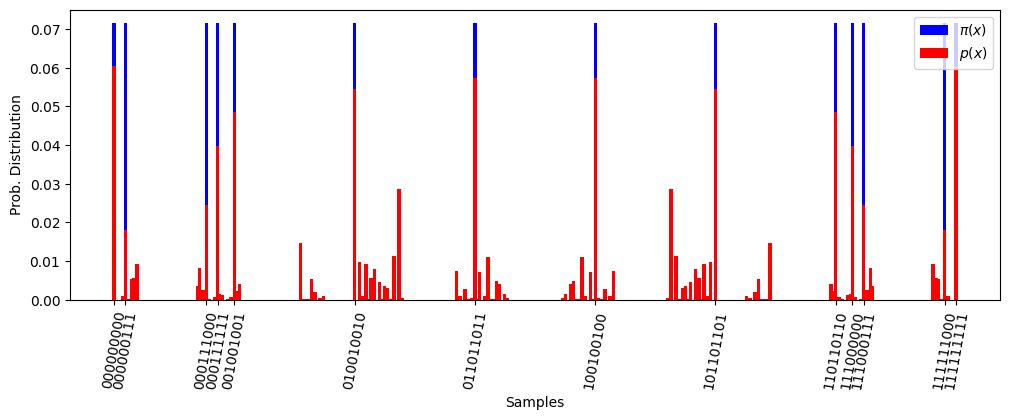

In [16]:
probs = np.zeros(2**size)
probs[nums] = 1 / len(data)

plt.figure(figsize=(12, 5))
plt.bar(np.arange(2**size), probs, width=2.0, label=r"$\pi(x)$", color='blue')
plt.bar(np.arange(2**size), output_probs, width=2.0, label=r"$p(x)$",color='red')

plt.xticks(nums, bitstrings, rotation=80)

plt.xlabel("Samples")
plt.ylabel("Prob. Distribution")
plt.legend(loc="upper right")
plt.subplots_adjust(bottom=0.3)
plt.show()

Accuracy of QDI Layer

In [17]:
acr2=0
for i in nums:
    acr2+=output_probs[i]
print(acr2)

0.60627493520685


# PQN layer

Choosing the PQN layer

In [18]:
@qml.qnode(dev)
def circuit(parameters):
    return pqn_layer(parameters)
jit_circuit = jax.jit(circuit)

Cost function

In [19]:
def costsquare(params):
    output_probs = jit_circuit(params)
    
    target_probs = probs
    cost_value = jnp.sum( jnp.square(target_probs-output_probs))
    return cost_value, target_probs

Optimize the quantum circuit

In [20]:

#params = np.random.random(size=n_qubits*4*3)
params = paramsoriginal


opt = optax.adam(learning_rate=0.1)
opt_state = opt.init(params)


@jax.jit
def update_step(params, opt_state):
    (loss_val, qcbm_probs), grads = jax.value_and_grad(costsquare, has_aux=True)(params)
    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_val


history3 = []
n_iterations = 100

for i in range(n_iterations):
    params, opt_state, loss_val = update_step(params, opt_state)

    if i%10==0:
        print(f"Step: {i} Loss: {loss_val:.4f}")

    history3.append(loss_val)
print(params)
optimal_params=params
output_probs = circuit(optimal_params)



#print(optimal_params)
#print(output_probs)

Step: 0 Loss: 0.0680
Step: 10 Loss: 0.0455
Step: 20 Loss: 0.0374
Step: 30 Loss: 0.0217
Step: 40 Loss: 0.0120
Step: 50 Loss: 0.0123
Step: 60 Loss: 0.0155
Step: 70 Loss: 0.0189
Step: 80 Loss: 0.0157
Step: 90 Loss: 0.0104
[ 4.65030519e-01 -5.57017127e-02  1.72321272e+00  5.48824376e-01
 -2.03965916e-01  9.81427380e-01  9.45047237e-03  3.69366523e-01
  5.53911458e-01  3.05438977e+00  1.02745768e+00  7.91481486e-01
  1.74188492e+00  1.14846975e+00  2.07238357e+00  1.31204381e+00
  1.37443579e+00 -1.86289304e-01  2.01769117e-01  7.37438979e-01
  3.96529232e-01  1.53892814e+00  2.13700346e-01  2.13926209e+00
 -1.40466743e-01  7.34111159e-01  8.29689093e-01  1.49662019e-01
  4.52546464e-03  1.41501805e-01  1.18708713e+00  7.05237689e-01
  7.60167574e-01  2.06221289e+00 -1.83033958e-01  1.48839037e+00
  6.05974298e-01  3.21545887e-01 -5.33686007e-01 -9.26741888e-03
  4.38875098e-01 -1.85511073e+00  3.80369885e-01  1.43889460e+00
 -4.23449773e-02 -4.22474559e-01  1.33426970e-02 -3.13959216e-01
 

Plot histogram of PQN layer

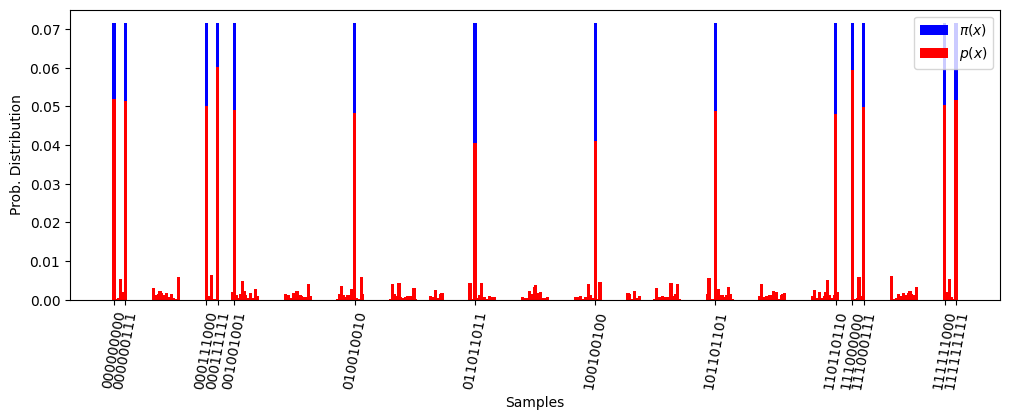

In [21]:
probs = np.zeros(2**size)
probs[nums] = 1 / len(data)

plt.figure(figsize=(12, 5))
plt.bar(np.arange(2**size), probs, width=2.0, label=r"$\pi(x)$", color='blue')
plt.bar(np.arange(2**size), output_probs, width=2.0, label=r"$p(x)$",color='red')

plt.xticks(nums, bitstrings, rotation=80)

plt.xlabel("Samples")
plt.ylabel("Prob. Distribution")
plt.legend(loc="upper right")
plt.subplots_adjust(bottom=0.3)
plt.show()

Accuracy of PQN layer

In [22]:
acr3=0
for i in nums:
    acr3+=output_probs[i]
print(acr3)

0.7003335014899882


# EFQ layer

Choosing the EFQ layer

In [23]:
@qml.qnode(dev)
def circuit(parameters):
    return efq_layer(parameters)
jit_circuit = jax.jit(circuit)

Cost function

In [24]:
def costsquare(params):
    output_probs = jit_circuit(params)
    
    target_probs = probs
    cost_value = jnp.sum( jnp.square(target_probs-output_probs))
    return cost_value, target_probs

Optimize the quantum circuit

In [25]:

#params = np.random.random(size=n_qubits*4*3)
params = paramsoriginal


opt = optax.adam(learning_rate=0.1)
opt_state = opt.init(params)


@jax.jit
def update_step(params, opt_state):
    (loss_val, qcbm_probs), grads = jax.value_and_grad(costsquare, has_aux=True)(params)
    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_val


history4 = []
n_iterations = 100

for i in range(n_iterations):
    params, opt_state, loss_val = update_step(params, opt_state)

    if i%10==0:
        print(f"Step: {i} Loss: {loss_val:.4f}")

    history4.append(loss_val)
print(params)
optimal_params=params
output_probs = circuit(optimal_params)



#print(optimal_params)
#print(output_probs)

Step: 0 Loss: 0.0706
Step: 10 Loss: 0.0460
Step: 20 Loss: 0.0306
Step: 30 Loss: 0.0193
Step: 40 Loss: 0.0127
Step: 50 Loss: 0.0101
Step: 60 Loss: 0.0069
Step: 70 Loss: 0.0033
Step: 80 Loss: 0.0012
Step: 90 Loss: 0.0005
[ 1.87782665e-01  5.04378590e-01  6.93856445e-01 -7.96297733e-02
 -4.54321144e-01  1.79808716e+00  3.59172868e-01  9.14618703e-01
  8.64686722e-01  1.73201781e-01  4.40244810e-01  1.19046455e+00
  2.52608171e-01 -1.98680308e-02  1.09945690e+00 -1.89560233e-02
 -5.59848319e-02  1.23754452e+00 -5.36389118e-02  4.89762815e-01
  1.57957049e+00  4.85226801e-01  2.38260303e-03  1.23520890e+00
  3.30875429e-03 -5.16466121e-02  1.06893001e+00 -1.76791198e-02
 -5.92688891e-01  1.49581972e+00  7.52645242e-01  4.94812743e-01
  3.31424339e-01  1.85099131e+00  1.17366454e+00  8.65483104e-01
 -5.37161527e-01  1.11831280e+00 -3.18155679e-01  1.04554170e+00
  2.15712977e+00  1.57018298e+00 -9.45145868e-01  1.02754916e+00
 -2.32899936e-01  1.19149104e+00 -8.09343688e-01  1.14019671e+00
 

Plot histogram of EFQ layer

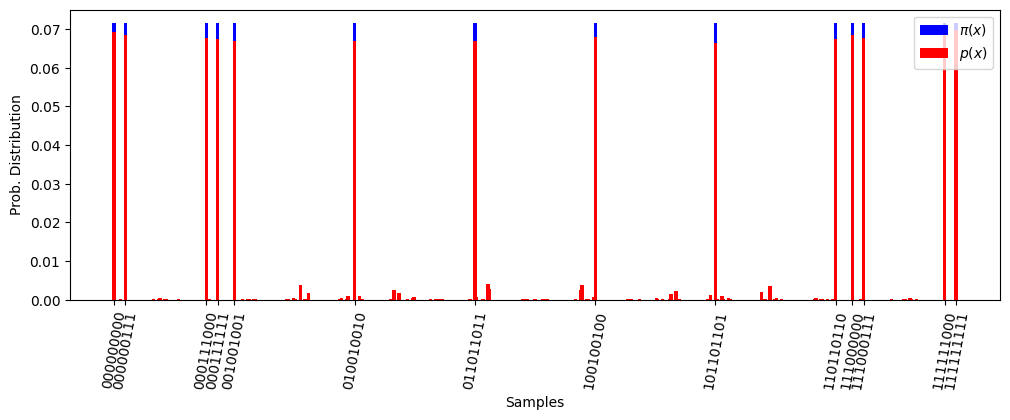

In [26]:
probs = np.zeros(2**size)
probs[nums] = 1 / len(data)

plt.figure(figsize=(12, 5))
plt.bar(np.arange(2**size), probs, width=2.0, label=r"$\pi(x)$", color='blue')
plt.bar(np.arange(2**size), output_probs, width=2.0, label=r"$p(x)$",color='red')

plt.xticks(nums, bitstrings, rotation=80)

plt.xlabel("Samples")
plt.ylabel("Prob. Distribution")
plt.legend(loc="upper right")
plt.subplots_adjust(bottom=0.3)
plt.show()

Accuracy of EFQ layer

In [27]:
acr4=0
for i in nums:
    acr4+=output_probs[i]
print(acr4)

0.9496537902608886


# Result comparision

Loss graph of all layers

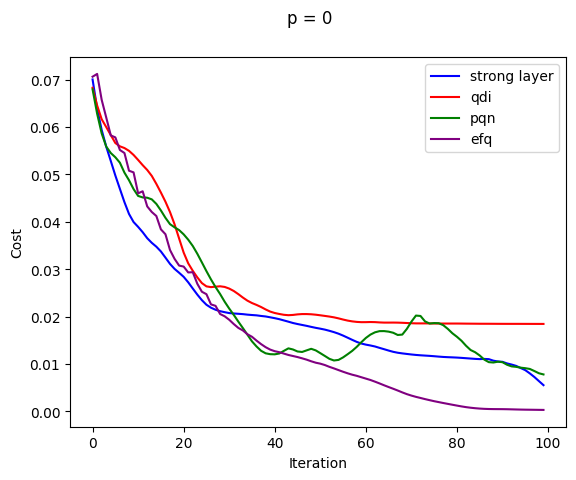

In [32]:
plt.plot(history, color='blue', label='strong layer')
plt.plot(history2, color='red', label='qdi')
plt.plot(history3, color='green', label='pqn')
plt.plot(history4, color='purple', label='efq')

plt.suptitle('p = '+ str(p))
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.legend(loc="upper right")
plt.show()